# Deep Q Learning implementation for Mountain Car V0

* Deep Q-learning approach to the Mountain Car problem
* This code implements the algorithm described at: [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
* Author: Marcelo Roger García Escalante [Personal Repository](https://github.com/CheloGE)

In [1]:
import gym
import numpy as np
import random
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Dropout
from keras.optimizers import Adam, RMSprop

from collections import deque

class DQN:
    def __init__(self, env,memory_size=1000,batch_size=32,stacked_states=1,gamma=1,init_epsilon=1, \
                 epsilon_min=0,epsilon_decay=0.8, learning_rate=0.01):
        self.env     = env
        self.memory  = deque(maxlen=memory_size)
        self.stacked_states = stacked_states # number of stacked states
        self.gamma = gamma
        self.epsilon = init_epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay#0.985#0.00005
        self.learning_rate = learning_rate
        self.batch_size = batch_size#64
        self.model        = self.create_model()
        self.target_model = self.create_model()
        self.target_update() # updates target model to have the same initial weights of the main model
        #self.model.summary()
        self.SUCCESS_REWARD = 10
        self.PUNISH_REWARD = -10
        self.GOAL_POSITION = 0.8/0.9
        self.LEFT_EDGE_POSITION = -1
        self.BOTTOM_POSITION = -0.2/0.9
        self.LEFT_LIMIT_STARTING_POSITION = -0.3/0.9
        self.RIGHT_LIMIT_STARTING_POSITION = -0.1/0.9
        self.MOTOR_LEFT = 0
        self.MOTOR_RIGHT = 2
        self.MOTOR_OFF = 1
    
    def init_state(self):
        # initial random state stacked
        obs = self.env.reset().reshape(1,2)
        self.state = np.concatenate((obs,)*self.stacked_states,axis=0)
        return self.state
        
    def create_model(self):
        model   = Sequential()
        state_shape  = (self.stacked_states,)+self.env.observation_space.shape
        model.add(Dense(200,use_bias=True, input_shape=state_shape,
                        kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(0.01)))
        #model.add(Dropout(0.1))
        model.add(BatchNormalization(axis=1))
        model.add(Activation('relu'))
        model.add(Flatten()) #in case stacked states are introduced

        model.add(Dense(self.env.action_space.n, activation='linear', kernel_initializer='lecun_uniform', 
                        kernel_regularizer=regularizers.l2(0.01),use_bias=True))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))
        #model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=self.learning_rate))
        return model

    def act(self, state):
        state=np.expand_dims(state,axis=0)
        #self.epsilon *= self.epsilon_decay
        #self.epsilon -= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def learnDoubleQL(self):
        # learning stage
        states=[]
        targets=[]
        batch_size = self.batch_size
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            state=np.expand_dims(state,axis=0)
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                new_state=np.expand_dims(new_state,axis=0)
                argmax_Q_future = np.argmax(self.model.predict(new_state)[0])
                DQ_future= self.target_model.predict(new_state)[0][argmax_Q_future]
                target[0][action] = reward + DQ_future * self.gamma
                states.append(state.reshape(self.stacked_states,2))
                targets.append(target.reshape(3))
        states=np.array(states)
        targets=np.array(targets)
        ###print("states shape:{}".format(states.shape))
        ###print("targets shape:{}".format(targets.shape))
        self.model.train_on_batch(states,targets)
            ###self.model.fit(state, target, epochs=1, verbose=0)
    def learn(self):
        #learning stage
        states=[]
        targets=[]
        batch_size = self.batch_size
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            state=np.expand_dims(state,axis=0)
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                new_state=np.expand_dims(new_state,axis=0)
                Q_future = max(self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
                states.append(state.reshape(self.stacked_states,2))
                targets.append(target.reshape(3))
        states=np.array(states)
        targets=np.array(targets)
        ###print("states shape:{}".format(states.shape))
        ###print("targets shape:{}".format(targets.shape))
        self.model.train_on_batch(states,targets)
            ###self.model.fit(state, target, epochs=1, verbose=0)
            
    
    def stateProcessing(self,new_state):
        #This function preprocess and concatenates last observation with history of states
        state_history=self.state
        new_state=new_state.reshape(1,2)
        new_state=self.normalize_data(new_state)
        self.state=np.concatenate((state_history[1:],new_state),axis=0)
        return self.state
    
    def custom_reward(self,reward,action,step):
        #####################################################################################
        #This function adds and subtracts custom rewards to the game's original reward system
        ####################################################################################
        # reward if goal is achieved
        if self.state[len(self.state)-1][0] >= self.GOAL_POSITION:
            reward += self.SUCCESS_REWARD
        # punish if touch the edge of wrong mountain
        elif self.state[len(self.state)-1][0] <= self.LEFT_EDGE_POSITION+0.1: 
            reward += self.PUNISH_REWARD
        
        pos,vel=zip(*self.state)
        # reward if action right is used at the rigth edge just before the goal
        if pos[len(self.state)-1]>=0.7 and action == self.MOTOR_RIGHT:
            reward += self.SUCCESS_REWARD
        # punish if speed drops abruptly when it was high, right ascending    
        if vel[len(self.state)-1]>=0.3 \
            and self.RIGHT_LIMIT_STARTING_POSITION>=pos[len(self.state)-1]>=self.LEFT_EDGE_POSITION+0.1 \
            and (action ==self.MOTOR_LEFT or action==self.MOTOR_OFF):
            reward += 2.5*self.PUNISH_REWARD
        # punish if speed drops abruptly when it was high, left ascending
        if vel[len(self.state)-1]<-0.3 \
            and self.RIGHT_LIMIT_STARTING_POSITION>=pos[len(self.state)-1]>=self.LEFT_LIMIT_STARTING_POSITION \
            and action ==self.MOTOR_RIGHT:
            reward += 2*self.PUNISH_REWARD

        if action == self.MOTOR_OFF:
            reward += 10*self.PUNISH_REWARD
        # punish whenever motor going right results in a velocity of going left due to gravity
        if pos[len(self.state)-1]>self.BOTTOM_POSITION and action == self.MOTOR_RIGHT and vel[len(self.state)-1]<0:
            reward += 2*self.PUNISH_REWARD
        # punish whenever motor going left results in a velocity of going right due to gravity
        elif pos[len(self.state)-1]<self.BOTTOM_POSITION and action == self.MOTOR_LEFT and vel[len(self.state)-1]>0:
            reward += 2*self.PUNISH_REWARD
        
        # punish whenever right altitude is low in conjunction of a low speed
        if self.GOAL_POSITION-0.3>=pos[len(self.state)-1]>=self.RIGHT_LIMIT_STARTING_POSITION+0.05 \
            and vel[len(self.state)-1] <= 0.2:
            reward += 2*self.PUNISH_REWARD

        #print("velocity:{}".format(vel[len(self.state)-1]),end="\r")
        #print("state:{}, velocity change:{}".format(list(vel),reward),end="\r")
        #print("state:{}, std:{}".format(list(pos),np.std(pos)),end="\r")
        return reward
          
    def target_update(self):
        new_target_weights = self.model.get_weights()
        self.target_model.set_weights(new_target_weights)

    def save_model(self, fn):
        self.model.save(fn)
        
    def normalize_data(self,states):
        if len(states)>1: 
            for i, state in enumerate(states):
                position = state[0]
                velocity = state[1]
                states[i][0] = (position + 0.3)/0.9
                states[i][1] = (velocity)/0.07
        else:
            position = states[0][0]
            velocity = states[0][1]
            states[0][0] = (position + 0.3)/0.9
            states[0][1] = (velocity)/0.07
        self.state = states
        return self.state
    def epsilon_update(self, new_epsilon):
        self.epsilon=new_epsilon
    def train_from_previous_model(self, file_name,initial_epsilon=0):
        temp_model=load_model(file_name)
        temp_weights=temp_model.get_weights()
        self.target_model.set_weights(temp_weights)
        self.model.set_weights(temp_weights)
        self.epsilon=initial_epsilon
def main():
    env     = gym.make("MountainCar-v0")
    EPISODES  = 1000
    STEPS = 200
    SKIPPED_FRAMES = 4
    RANDOM_EPISODES = 0 # completely random episodes independent from epsilon decay at start
    MEMORY_SIZE=5000
    STACKED_STATES = 1 # number of stacked states ( 1 means no stacked state)
    GAMMA = 0.99
    INIT_EPSILON = 0.8
    EPSILON_MIN = 0.01
    EPSILON_DECAY = 0.99
    LEARNING_RATE = 0.005
    BATCH_SIZE = 128#64
    PACE_OF_TARGET_UPDATE = 6 # updates target model every N episodes 
    RENDER_TRAINING = True
    Double_DQN = False
    #creating an instance of DQN agent class
    dqn_agent = DQN(env=env,memory_size=MEMORY_SIZE,batch_size=BATCH_SIZE,stacked_states=STACKED_STATES, 
                    gamma=GAMMA,init_epsilon=INIT_EPSILON, epsilon_min=EPSILON_MIN,epsilon_decay=EPSILON_DECAY,
                    learning_rate=LEARNING_RATE)
    
    # uncomment next line if train from previous model is required
    #dqn_agent.train_from_previous_model("success.model",initial_epsilon=0.01)
    
    #variables for 100 average reward history
    last100Scores = [0] * 100
    last100ScoresIndex = 0
    last100Filled = False
    reward_history=[]
    
    for episode in range(1,EPISODES+1):
        state=dqn_agent.init_state()
        state=dqn_agent.normalize_data(state)
        tot_reward = 0.0 # system's reward counter
        custom_reward = 0.0 # custom's reward counter 
        for step in range(1,STEPS+1):
            
            if episode <= RANDOM_EPISODES:
                temp_action=env.action_space.sample()
            else:
                temp_action = dqn_agent.act(state)
            
            if step%SKIPPED_FRAMES==0:
                action=temp_action
            elif step==1:
                action=temp_action
           
            print("action: "+str(action),end='\r')
            if RENDER_TRAINING:
                env.render()
            new_state, reward, done, _ = env.step(action)
            tot_reward += reward
            new_state = dqn_agent.stateProcessing(new_state)
            if step > dqn_agent.stacked_states:
                reward = dqn_agent.custom_reward(reward,action,step)
                
            custom_reward+= reward
            dqn_agent.remember(state, action, reward, new_state, done)
            if step%2==0:
                if not Double_DQN:
                    dqn_agent.learn()
                else:
                    dqn_agent.learnDoubleQL()
            
            state = new_state
            if done:
                if episode%PACE_OF_TARGET_UPDATE==0:
                    dqn_agent.target_update() # updates target model
   
                last100Scores[last100ScoresIndex] = tot_reward
                last100ScoresIndex += 1
                if last100ScoresIndex >= 100:
                    last100Filled = True
                    last100ScoresIndex = 0
                break
        if last100Filled:
            reward_history.append(sum(last100Scores)/len(last100Scores))
        else:
            reward_history.append(tot_reward)
        if tot_reward <= -199:
            
            if not last100Filled:
            
                print("Failed to complete in episode {} with reward:{} and custom reward:{} ".format(episode,tot_reward,custom_reward))
            else:
                print("Failed to complete in episode {} with reward:{} and custom reward:{}, Avg reward:{}".format(episode,tot_reward,custom_reward,sum(last100Scores)/len(last100Scores)))

                
                
        else:
            if not last100Filled:
                print("### Completed in {} episodes with reward:{} and custom reward:{} ###".format(episode,tot_reward,custom_reward))
            else: 
                print("### Completed in {} episodes with reward:{} and custom reward:{}, Avg reward:{} ###".format(episode,tot_reward,custom_reward,sum(last100Scores)/len(last100Scores)))

            dqn_agent.save_model("success.model")
        if sum(last100Scores)/len(last100Scores) >= -110 and last100Filled:
            break
        if episode>RANDOM_EPISODES:
            dqn_agent.epsilon *= dqn_agent.epsilon_decay
            print("Epsilon: "+str(dqn_agent.epsilon))
    return reward_history

/home/mrgarciae/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Run Model

In [2]:
reward_history=main()

/home/mrgarciae/Desktop/Udacity/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 200)            600       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 200)            4         
_________________________________________________________________
activation_1 (Activation)    (None, 1, 200)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 1,207
Trainable params: 1,205
Non-trainable params: 2
_________________________________________________________________
Failed to complete in episode 1 with rewa

Failed to complete in episode 68 with reward:-200.0 and custom reward:-4065.0 
Epsilon: 0.40390871102965575
### Completed in 69 episodes with reward:-152.0 and custom reward:-2952.0 ###
Epsilon: 0.3998696239193592
Failed to complete in episode 70 with reward:-200.0 and custom reward:-4720.0 
Epsilon: 0.39587092768016563
Failed to complete in episode 71 with reward:-200.0 and custom reward:-5170.0 
Epsilon: 0.391912218403364
### Completed in 72 episodes with reward:-175.0 and custom reward:-2725.0 ###
Epsilon: 0.38799309621933037
Failed to complete in episode 73 with reward:-200.0 and custom reward:-3900.0 
Epsilon: 0.38411316525713707
Failed to complete in episode 74 with reward:-200.0 and custom reward:-4115.0 
Epsilon: 0.3802720336045657
### Completed in 75 episodes with reward:-156.0 and custom reward:-3076.0 ###
Epsilon: 0.37646931326852
Failed to complete in episode 76 with reward:-200.0 and custom reward:-4220.0 
Epsilon: 0.37270462013583483
Failed to complete in episode 77 with 

### Completed in 138 episodes with reward:-159.0 and custom reward:-2699.0, Avg reward:-178.86 ###
Epsilon: 0.19986964516676248
### Completed in 139 episodes with reward:-143.0 and custom reward:-753.0, Avg reward:-178.29 ###
Epsilon: 0.19787094871509486
### Completed in 140 episodes with reward:-189.0 and custom reward:-3839.0, Avg reward:-178.18 ###
Epsilon: 0.1958922392279439
### Completed in 141 episodes with reward:-145.0 and custom reward:-1935.0, Avg reward:-177.63 ###
Epsilon: 0.19393331683566448
### Completed in 142 episodes with reward:-124.0 and custom reward:-944.0, Avg reward:-177.32 ###
Epsilon: 0.19199398366730783
### Completed in 143 episodes with reward:-139.0 and custom reward:-869.0, Avg reward:-177.04 ###
Epsilon: 0.19007404383063475
### Completed in 144 episodes with reward:-142.0 and custom reward:-982.0, Avg reward:-176.75 ###
Epsilon: 0.1881733033923284
### Completed in 145 episodes with reward:-150.0 and custom reward:-2630.0, Avg reward:-176.25 ###
Epsilon: 0.

Failed to complete in episode 203 with reward:-200.0 and custom reward:-2875.0, Avg reward:-164.52
Epsilon: 0.10400027562800446
### Completed in 204 episodes with reward:-138.0 and custom reward:-888.0, Avg reward:-163.9 ###
Epsilon: 0.1029602728717244
Failed to complete in episode 205 with reward:-200.0 and custom reward:-970.0, Avg reward:-164.59
Epsilon: 0.10193067014300716
### Completed in 206 episodes with reward:-138.0 and custom reward:-718.0, Avg reward:-164.52 ###
Epsilon: 0.10091136344157708
### Completed in 207 episodes with reward:-144.0 and custom reward:-1124.0, Avg reward:-164.53 ###
Epsilon: 0.09990224980716131
### Completed in 208 episodes with reward:-142.0 and custom reward:-912.0, Avg reward:-163.95 ###
Epsilon: 0.0989032273090897
### Completed in 209 episodes with reward:-197.0 and custom reward:-627.0, Avg reward:-163.92 ###
Epsilon: 0.0979141950359988
### Completed in 210 episodes with reward:-143.0 and custom reward:-538.0, Avg reward:-163.96 ###
Epsilon: 0.0969

### Completed in 268 episodes with reward:-145.0 and custom reward:-370.0, Avg reward:-163.88 ###
Epsilon: 0.054115557776051766
### Completed in 269 episodes with reward:-141.0 and custom reward:-391.0, Avg reward:-163.78 ###
Epsilon: 0.053574402198291245
### Completed in 270 episodes with reward:-160.0 and custom reward:-460.0, Avg reward:-163.98 ###
Epsilon: 0.05303865817630833
### Completed in 271 episodes with reward:-161.0 and custom reward:-1101.0, Avg reward:-164.17 ###
Epsilon: 0.05250827159454525
Failed to complete in episode 272 with reward:-200.0 and custom reward:-1115.0, Avg reward:-164.75
Epsilon: 0.0519831888785998
### Completed in 273 episodes with reward:-148.0 and custom reward:-548.0, Avg reward:-164.87 ###
Epsilon: 0.051463356989813795
### Completed in 274 episodes with reward:-149.0 and custom reward:-999.0, Avg reward:-164.91 ###
Epsilon: 0.05094872341991566
Failed to complete in episode 275 with reward:-200.0 and custom reward:-1140.0, Avg reward:-164.94
Epsilon:

### Completed in 333 episodes with reward:-145.0 and custom reward:-660.0, Avg reward:-157.86 ###
Epsilon: 0.02815851761670362
### Completed in 334 episodes with reward:-148.0 and custom reward:-573.0, Avg reward:-157.91 ###
Epsilon: 0.027876932440536583
### Completed in 335 episodes with reward:-169.0 and custom reward:-949.0, Avg reward:-157.6 ###
Epsilon: 0.027598163116131218
### Completed in 336 episodes with reward:-141.0 and custom reward:-591.0, Avg reward:-157.65 ###
Epsilon: 0.027322181484969905
### Completed in 337 episodes with reward:-87.0 and custom reward:23.0, Avg reward:-157.14 ###
Epsilon: 0.027048959670120207
### Completed in 338 episodes with reward:-145.0 and custom reward:-850.0, Avg reward:-157.2 ###
Epsilon: 0.026778470073419006
### Completed in 339 episodes with reward:-152.0 and custom reward:-762.0, Avg reward:-156.98 ###
Epsilon: 0.026510685372684816
### Completed in 340 episodes with reward:-144.0 and custom reward:-1099.0, Avg reward:-156.48 ###
Epsilon: 0.

### Completed in 398 episodes with reward:-145.0 and custom reward:-655.0, Avg reward:-133.73 ###
Epsilon: 0.01465201777373343
### Completed in 399 episodes with reward:-148.0 and custom reward:-798.0, Avg reward:-133.5 ###
Epsilon: 0.014505497595996095
### Completed in 400 episodes with reward:-137.0 and custom reward:-537.0, Avg reward:-133.42 ###
Epsilon: 0.014360442620036135
### Completed in 401 episodes with reward:-137.0 and custom reward:-537.0, Avg reward:-133.0 ###
Epsilon: 0.014216838193835773
### Completed in 402 episodes with reward:-142.0 and custom reward:-622.0, Avg reward:-133.49 ###
Epsilon: 0.014074669811897415
### Completed in 403 episodes with reward:-146.0 and custom reward:-616.0, Avg reward:-133.45 ###
Epsilon: 0.01393392311377844
### Completed in 404 episodes with reward:-146.0 and custom reward:-471.0, Avg reward:-133.42 ###
Epsilon: 0.013794583882640656
### Completed in 405 episodes with reward:-101.0 and custom reward:79.0, Avg reward:-133.58 ###
Epsilon: 0.0

### Completed in 466 episodes with reward:-145.0 and custom reward:-605.0, Avg reward:-132.05 ###
Epsilon: 0.0099
### Completed in 467 episodes with reward:-149.0 and custom reward:-679.0, Avg reward:-132.39 ###
Epsilon: 0.0099
### Completed in 468 episodes with reward:-88.0 and custom reward:-58.0, Avg reward:-131.79 ###
Epsilon: 0.0099
### Completed in 469 episodes with reward:-149.0 and custom reward:-1089.0, Avg reward:-131.83 ###
Epsilon: 0.0099
### Completed in 470 episodes with reward:-178.0 and custom reward:-1118.0, Avg reward:-132.27 ###
Epsilon: 0.0099
### Completed in 471 episodes with reward:-158.0 and custom reward:-768.0, Avg reward:-132.88 ###
Epsilon: 0.0099
### Completed in 472 episodes with reward:-98.0 and custom reward:-38.0, Avg reward:-132.99 ###
Epsilon: 0.0099
Failed to complete in episode 473 with reward:-200.0 and custom reward:-2895.0, Avg reward:-133.46
Epsilon: 0.0099
### Completed in 474 episodes with reward:-98.0 and custom reward:52.0, Avg reward:-133.5

### Completed in 539 episodes with reward:-145.0 and custom reward:-595.0, Avg reward:-133.65 ###
Epsilon: 0.0099
Failed to complete in episode 540 with reward:-200.0 and custom reward:-1900.0, Avg reward:-134.19
Epsilon: 0.0099
### Completed in 541 episodes with reward:-92.0 and custom reward:28.0, Avg reward:-133.57 ###
Epsilon: 0.0099
### Completed in 542 episodes with reward:-153.0 and custom reward:-843.0, Avg reward:-133.57 ###
Epsilon: 0.0099
### Completed in 543 episodes with reward:-153.0 and custom reward:-783.0, Avg reward:-133.65 ###
Epsilon: 0.0099
### Completed in 544 episodes with reward:-149.0 and custom reward:-649.0, Avg reward:-134.2 ###
Epsilon: 0.0099
### Completed in 545 episodes with reward:-145.0 and custom reward:-575.0, Avg reward:-133.65 ###
Epsilon: 0.0099
### Completed in 546 episodes with reward:-95.0 and custom reward:35.0, Avg reward:-133.19 ###
Epsilon: 0.0099
### Completed in 547 episodes with reward:-87.0 and custom reward:13.0, Avg reward:-133.2 ###


### Completed in 612 episodes with reward:-101.0 and custom reward:69.0, Avg reward:-131.58 ###
Epsilon: 0.0099
### Completed in 613 episodes with reward:-147.0 and custom reward:-1012.0, Avg reward:-132.2 ###
Epsilon: 0.0099
Failed to complete in episode 614 with reward:-200.0 and custom reward:-2120.0, Avg reward:-133.02
Epsilon: 0.0099
### Completed in 615 episodes with reward:-90.0 and custom reward:20.0, Avg reward:-132.18 ###
Epsilon: 0.0099
### Completed in 616 episodes with reward:-145.0 and custom reward:-575.0, Avg reward:-132.75 ###
Epsilon: 0.0099
### Completed in 617 episodes with reward:-145.0 and custom reward:-575.0, Avg reward:-132.42 ###
Epsilon: 0.0099
### Completed in 618 episodes with reward:-152.0 and custom reward:-2277.0, Avg reward:-133.0 ###
Epsilon: 0.0099
### Completed in 619 episodes with reward:-162.0 and custom reward:-882.0, Avg reward:-133.13 ###
Epsilon: 0.0099
### Completed in 620 episodes with reward:-88.0 and custom reward:12.0, Avg reward:-132.52 #

### Completed in 685 episodes with reward:-88.0 and custom reward:-18.0, Avg reward:-131.26 ###
Epsilon: 0.0099
Failed to complete in episode 686 with reward:-200.0 and custom reward:-1850.0, Avg reward:-131.26
Epsilon: 0.0099
Failed to complete in episode 687 with reward:-200.0 and custom reward:-1920.0, Avg reward:-131.81
Epsilon: 0.0099
### Completed in 688 episodes with reward:-150.0 and custom reward:-600.0, Avg reward:-132.32 ###
Epsilon: 0.0099
### Completed in 689 episodes with reward:-87.0 and custom reward:3.0, Avg reward:-131.46 ###
Epsilon: 0.0099
Failed to complete in episode 690 with reward:-200.0 and custom reward:-1920.0, Avg reward:-131.56
Epsilon: 0.0099
### Completed in 691 episodes with reward:-150.0 and custom reward:-600.0, Avg reward:-131.55 ###
Epsilon: 0.0099
### Completed in 692 episodes with reward:-98.0 and custom reward:62.0, Avg reward:-131.66 ###
Epsilon: 0.0099
### Completed in 693 episodes with reward:-145.0 and custom reward:-605.0, Avg reward:-131.96 

### Completed in 758 episodes with reward:-105.0 and custom reward:65.0, Avg reward:-137.56 ###
Epsilon: 0.0099
### Completed in 759 episodes with reward:-92.0 and custom reward:18.0, Avg reward:-136.67 ###
Epsilon: 0.0099
### Completed in 760 episodes with reward:-94.0 and custom reward:36.0, Avg reward:-136.16 ###
Epsilon: 0.0099
### Completed in 761 episodes with reward:-153.0 and custom reward:-733.0, Avg reward:-136.72 ###
Epsilon: 0.0099
### Completed in 762 episodes with reward:-161.0 and custom reward:-881.0, Avg reward:-137.38 ###
Epsilon: 0.0099
### Completed in 763 episodes with reward:-193.0 and custom reward:-743.0, Avg reward:-138.45 ###
Epsilon: 0.0099
### Completed in 764 episodes with reward:-87.0 and custom reward:3.0, Avg reward:-137.32 ###
Epsilon: 0.0099
### Completed in 765 episodes with reward:-170.0 and custom reward:-760.0, Avg reward:-137.4 ###
Epsilon: 0.0099
### Completed in 766 episodes with reward:-165.0 and custom reward:-895.0, Avg reward:-137.6 ###
Epsi

### Completed in 831 episodes with reward:-89.0 and custom reward:11.0, Avg reward:-134.12 ###
Epsilon: 0.0099
### Completed in 832 episodes with reward:-149.0 and custom reward:-639.0, Avg reward:-133.84 ###
Epsilon: 0.0099
### Completed in 833 episodes with reward:-85.0 and custom reward:5.0, Avg reward:-133.75 ###
Epsilon: 0.0099
### Completed in 834 episodes with reward:-91.0 and custom reward:19.0, Avg reward:-133.25 ###
Epsilon: 0.0099
### Completed in 835 episodes with reward:-166.0 and custom reward:-776.0, Avg reward:-133.3 ###
Epsilon: 0.0099
### Completed in 836 episodes with reward:-90.0 and custom reward:10.0, Avg reward:-132.54 ###
Epsilon: 0.0099
### Completed in 837 episodes with reward:-153.0 and custom reward:-1223.0, Avg reward:-132.37 ###
Epsilon: 0.0099
### Completed in 838 episodes with reward:-149.0 and custom reward:-759.0, Avg reward:-132.09 ###
Epsilon: 0.0099
### Completed in 839 episodes with reward:-149.0 and custom reward:-649.0, Avg reward:-131.99 ###
Eps

### Completed in 904 episodes with reward:-157.0 and custom reward:-797.0, Avg reward:-131.57 ###
Epsilon: 0.0099
### Completed in 905 episodes with reward:-108.0 and custom reward:82.0, Avg reward:-131.71 ###
Epsilon: 0.0099
### Completed in 906 episodes with reward:-145.0 and custom reward:-585.0, Avg reward:-132.04 ###
Epsilon: 0.0099
### Completed in 907 episodes with reward:-149.0 and custom reward:-709.0, Avg reward:-131.83 ###
Epsilon: 0.0099
### Completed in 908 episodes with reward:-145.0 and custom reward:-585.0, Avg reward:-131.66 ###
Epsilon: 0.0099
### Completed in 909 episodes with reward:-87.0 and custom reward:3.0, Avg reward:-131.66 ###
Epsilon: 0.0099
### Completed in 910 episodes with reward:-153.0 and custom reward:-703.0, Avg reward:-132.09 ###
Epsilon: 0.0099
### Completed in 911 episodes with reward:-111.0 and custom reward:99.0, Avg reward:-131.75 ###
Epsilon: 0.0099
### Completed in 912 episodes with reward:-149.0 and custom reward:-639.0, Avg reward:-132.35 ##

### Completed in 977 episodes with reward:-149.0 and custom reward:-709.0, Avg reward:-133.74 ###
Epsilon: 0.0099
### Completed in 978 episodes with reward:-107.0 and custom reward:83.0, Avg reward:-133.32 ###
Epsilon: 0.0099
### Completed in 979 episodes with reward:-161.0 and custom reward:-901.0, Avg reward:-133.47 ###
Epsilon: 0.0099
### Completed in 980 episodes with reward:-87.0 and custom reward:3.0, Avg reward:-132.85 ###
Epsilon: 0.0099
### Completed in 981 episodes with reward:-177.0 and custom reward:-737.0, Avg reward:-133.73 ###
Epsilon: 0.0099
### Completed in 982 episodes with reward:-150.0 and custom reward:-660.0, Avg reward:-133.74 ###
Epsilon: 0.0099
### Completed in 983 episodes with reward:-108.0 and custom reward:82.0, Avg reward:-133.33 ###
Epsilon: 0.0099
### Completed in 984 episodes with reward:-90.0 and custom reward:20.0, Avg reward:-133.37 ###
Epsilon: 0.0099
### Completed in 985 episodes with reward:-161.0 and custom reward:-881.0, Avg reward:-133.65 ###
E

# Testing DQN algorithm

In [14]:
from keras.models import load_model
import time
env = gym.make('MountainCar-v0') 
dqn_agent = DQN(env=env)
model = load_model('success_model.model')
sum_rewards = 0.0
for i in range(100):    
    state=dqn_agent.init_state()
    
    done = False
    tot_reward = 0.0
    while not done:
        env.render()                    # Uncomment to see game running
        time.sleep(0.01)
        state=np.expand_dims(state,axis=0)
        Q = model.predict(state)        
        action = np.argmax(Q)         
        new_state, reward, done, info = env.step(action)
        state = dqn_agent.stateProcessing(new_state)
        tot_reward += reward
    sum_rewards += tot_reward
    print('Last Game ended! Total reward: {}'.format(tot_reward),end="\r")
print()
print('Final 100 average reward:'+str(sum_rewards/100))


/home/mrgarciae/Desktop/Udacity/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Last Game ended! Total reward: -148.0
Final 100 average reward:-129.1


# 100-Average Reward Graph

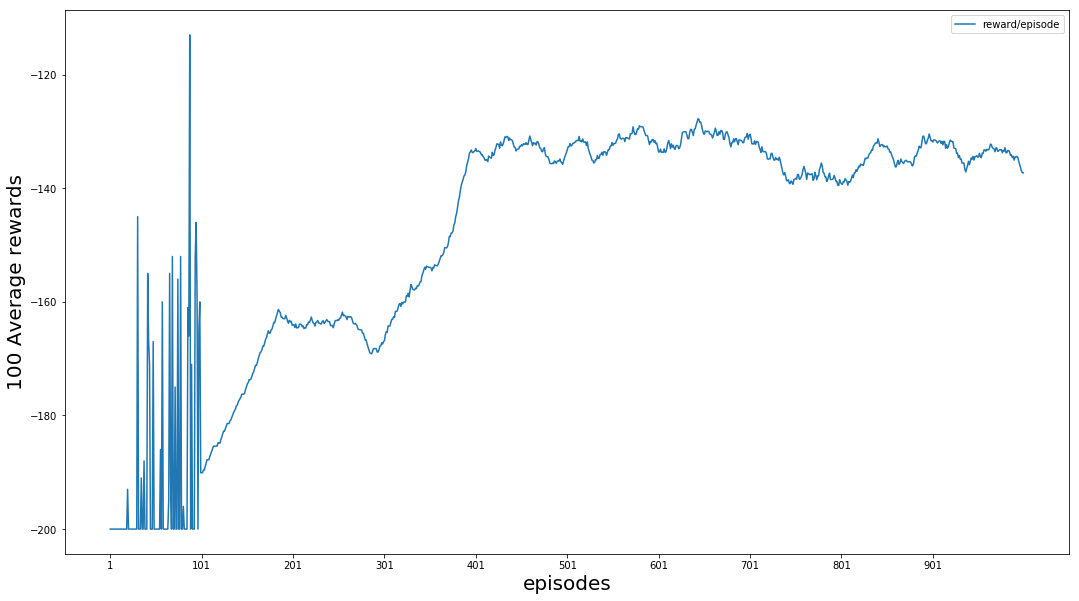

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
EPISODES_PACE = 1
plt.figure(figsize=(18,10))
X = np.arange(1,len(reward_history)+1,EPISODES_PACE)
y = reward_history[0::EPISODES_PACE]
plt.plot(X, y, label='reward/episode')
plt.legend()
plt.xticks(np.arange(1,len(reward_history)+1,100))
plt.xlabel('episodes', fontsize=20)
plt.ylabel('100 Average rewards',fontsize=20)
_ = plt.ylim()

# Testing random algorithm 

In [7]:
import gym
import numpy as np
import random
import time
env = gym.make('MountainCar-v0') 

sum_rewards = 0.0
for i in range(100):    
    done = False
    state = env.reset()
    tot_reward = 0.0
    while not done:
        env.render()                    # Uncomment to see game running
        time.sleep(0.01)       
        action = env.action_space.sample()      
        state, reward, done, info = env.step(action)
        tot_reward += reward
    sum_rewards += tot_reward
    print('Last Game ended! Total reward: {}'.format(tot_reward),end="\r")
print()
print('Final 100 average reward:'+str(sum_rewards/100))
env.close()

/home/mrgarciae/Desktop/Udacity/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Last Game ended! Total reward: -200.0
Final 100 average reward:-200.0
